In [1]:
import preamble
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(4, 4, kernel_size=5, stride=2, padding=2),  # (8, 128)
            nn.ReLU(),
            nn.Conv1d(4, 8, kernel_size=5, stride=2, padding=2), # (16, 64)
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=5, stride=2, padding=2), # (32, 32)
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2), # (64, 16)
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2), # (128, 8)
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2) # (256, 4)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1), # (128, 8)
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1), # (64, 16)
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1), # (32, 32)
            nn.ReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=5, stride=2, padding=2, output_padding=1), # (16, 64)
            nn.ReLU(),
            nn.ConvTranspose1d(8, 4, kernel_size=5, stride=2, padding=2, output_padding=1), # (8, 128)
            nn.ReLU(),
            nn.ConvTranspose1d(4, 4, kernel_size=5, stride=2, padding=2, output_padding=1)  # (4, 256)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from multimodal_pairs import MultimodalPairsDataset, MultimodalPairsSampler

# Prepare the dataset and data loader
data_dir = '../data/global_standardized_and_absolute_time_channel_multimodal_pairs'
dataset = MultimodalPairsDataset(data_dir)
sampler = MultimodalPairsSampler(
    dataset=dataset,
    no_action_prob=0.33,
    num_samples_per_epoch=620  # Specify samples per epoch
)

# Create DataLoader using the custom sampler
data_loader = DataLoader(
    dataset,
    batch_size=300,
    sampler=sampler
)

# Initialize the model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for forces, _ in data_loader:
        forces = forces.to(device)

        # Forward pass
        outputs = model(forces)
        loss = criterion(outputs, forces)  # Reconstruction loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete!")

/Users/kv/Documents/School/shared-language-force-embedding/src/multimodal_pairs.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  multimodal_pair = torch.load(file_path)


Epoch [1/500], Loss: 0.7635
Epoch [2/500], Loss: 0.7570
Epoch [3/500], Loss: 0.7231
Epoch [4/500], Loss: 0.6804
Epoch [5/500], Loss: 0.8797
Epoch [6/500], Loss: 0.6880
Epoch [7/500], Loss: 0.5816
Epoch [8/500], Loss: 0.5685
Epoch [9/500], Loss: 0.6178
Epoch [10/500], Loss: 0.5852
Epoch [11/500], Loss: 0.5730
Epoch [12/500], Loss: 0.5417
Epoch [13/500], Loss: 0.4981
Epoch [14/500], Loss: 0.5160
Epoch [15/500], Loss: 0.6021
Epoch [16/500], Loss: 0.4412
Epoch [17/500], Loss: 0.5476
Epoch [18/500], Loss: 0.4357
Epoch [19/500], Loss: 0.4500
Epoch [20/500], Loss: 0.4515
Epoch [21/500], Loss: 0.4711
Epoch [22/500], Loss: 0.4543
Epoch [23/500], Loss: 0.5120
Epoch [24/500], Loss: 0.3300
Epoch [25/500], Loss: 0.3798
Epoch [26/500], Loss: 0.4520
Epoch [27/500], Loss: 0.3928
Epoch [28/500], Loss: 0.4682
Epoch [29/500], Loss: 0.4220
Epoch [30/500], Loss: 0.7084
Epoch [31/500], Loss: 0.3747
Epoch [32/500], Loss: 0.4787
Epoch [33/500], Loss: 0.3575
Epoch [34/500], Loss: 0.4237
Epoch [35/500], Loss: 0

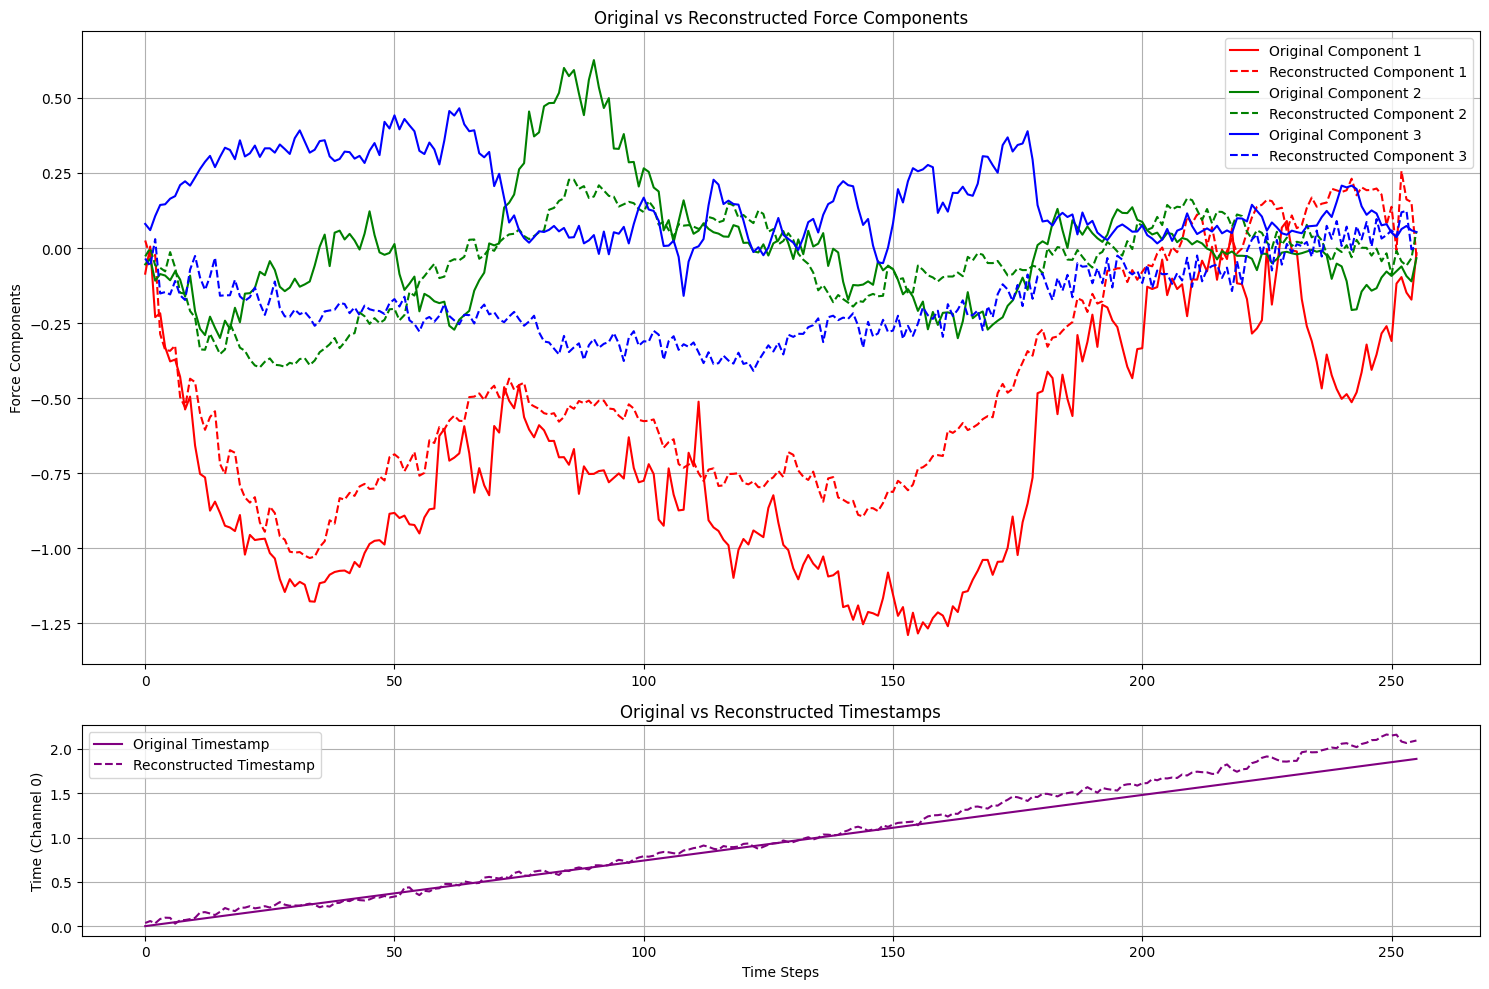

In [20]:
import matplotlib.pyplot as plt
import random
import torch

def plot_reconstructed_force(model, dataset, no_action_prob=0.5):
    """
    Plots the original and reconstructed force tensor for a randomly sampled multimodal pair,
    with control over the probability of sampling a no_action pair.

    Args:
        model: Trained autoencoder model.
        dataset: The dataset containing multimodal pairs.
        no_action_prob (float): Probability of selecting a no_action pair (default=0.5).
    """
    # Separate indices into action and no_action
    action_indices = [i for i, path in enumerate(dataset.file_paths) if "no_action" not in path]
    no_action_indices = [i for i, path in enumerate(dataset.file_paths) if "no_action" in path]

    # Sample based on probability
    if random.random() < no_action_prob:
        idx = random.choice(no_action_indices)  # Sample no_action pair
    else:
        idx = random.choice(action_indices)  # Sample action pair

    # Load the selected sample
    force_tensor, _ = dataset[idx]  # Original data
    force_tensor = force_tensor.unsqueeze(0).to(device)  # Add batch dim for model input

    # Pass through the model
    model.eval()
    with torch.no_grad():
        reconstructed = model(force_tensor).squeeze(0).cpu()  # Remove batch dim

    # Plot original and reconstructed forces
    time_steps = range(force_tensor.shape[2])  # Assuming length 256

    # Create 2 subplots: one for force components (1-3) and one for timestamps (0)
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

    # ----- Plot Force Components (1, 2, 3) -----
    colors = ['r', 'g', 'b']  # Colors for components 1, 2, 3
    for i in range(1, 4):  # Channels 1, 2, 3
        axs[0].plot(time_steps, force_tensor[0, i].cpu().numpy(), label=f'Original Component {i}', color=colors[i-1])
        axs[0].plot(time_steps, reconstructed[i].numpy(), label=f'Reconstructed Component {i}', color=colors[i-1], linestyle='--')

    axs[0].set_ylabel('Force Components')
    axs[0].set_title('Original vs Reconstructed Force Components')
    axs[0].legend()
    axs[0].grid(True)

    # ----- Plot Timestamps (0th Channel) -----
    axs[1].plot(time_steps, force_tensor[0, 0].cpu().numpy(), label='Original Timestamp', color='purple')
    axs[1].plot(time_steps, reconstructed[0].numpy(), label='Reconstructed Timestamp', color='purple', linestyle='--')

    axs[1].set_xlabel('Time Steps')
    axs[1].set_ylabel('Time (Channel 0)')
    axs[1].set_title('Original vs Reconstructed Timestamps')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

plot_reconstructed_force(model, dataset, no_action_prob=sampler.no_action_prob)